# Assignment 7: Bagging and Boosting

Only use the already imported library `numpy`, `matplotlib` and the Python standard library. For the evaluation you may also use scikit-learn (`sklearn`). Make sure that the dataset `titanic.csv` is in the same directory as the notebook.

List your team members (name and immatriculation number) and indicate whether you are a B.Sc. Data Science or other group in the following cell:

Zhuo Zeng 3489547

In [1]:
# You are allowed to use the numpy package and the DecisionTreeClassifier.
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier


def load_dataset(path):
    import pandas as pd
    from sklearn.model_selection import train_test_split

    df = pd.read_csv('titanic.csv')
    # The feature engineering mostly follows the notebook by Manav Segal: https://www.kaggle.com/startupsci/titanic-data-science-solutions
    # From the Name attribute we can extract titles, which gives insight about the social status/age/gender of the passenger.
    df['Title'] = df['Name'].str.extract(' ([a-zA-Z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    # We map the Title attribute to a one-hot encoding.
    df = df.join(pd.get_dummies(df['Title'], prefix='Title'))

    # We map the Sex attribute to a numeric representation.
    df['Sex'] = df['Sex'].map({'female': 1, 'male': 0}).astype(int)

    # We one-hot encode Pclass.
    df = df.join(pd.get_dummies(df['Pclass'], prefix='Pclass'))

    # Based on the number of sibling-spouses in SibSp and parents-childern in Parch, 
    # we can determine whether a passenger was on board alone.
    df['IsAlone'] = ((df['SibSp'] + df['Parch'] + 1) == 1).astype(int)

    # We remove all attributes that do not seem relevant to the prediction, or are already encoded in another attribute.
    df = df.drop(['PassengerId', 'Name', 'Title', 'Ticket', 'Cabin', 'Parch', 'SibSp'], axis=1)

    # For remaining features, we have to separate train and test, 
    # as we will impute missing data based on statistics in the training data.
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=2020)
    # For Embarked, we set all missing values to the most frequent port and then one-hot encode the attribute.
    def impute_embarked():    
        freq_port = df_train['Embarked'].dropna().mode()[0]
        output = []
        for df in (df_train, df_test):
            df = df.join(pd.get_dummies(df['Embarked'].fillna(freq_port), prefix='Embarked'))
            df = df.drop('Embarked', axis=1)
            output.append(df)
        return output

    df_train, df_test = impute_embarked()

    # For Age, we set missing values to the median dependent on the pair of Sex and Pclass.
    guess_ages = np.zeros((2, 3))
    for df in (df_train, df_test):
        for i in range(2):
            for j in range(3):
                guess_ages[i, j] = df[(df['Sex'] == i) & (df['Pclass'] == j+1)]['Age'].dropna().median()
        for i in range(2):
            for j in range(3):
                df.loc[(df['Age'].isnull()) & (df['Sex'] == i) & (df['Pclass'] == j+1), 'Age'] = guess_ages[i, j]
        df['Age'] = df['Age'].astype(int)

    df_train = df_train.drop(['Pclass'], axis=1)
    df_test = df_test.drop(['Pclass'], axis=1)

    X_train = df_train.values[:, 1:]
    X_test = df_test.values[:, 1:]
    y_train = df_train.values[:, 0]
    y_test = df_test.values[:, 0]
    
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = load_dataset('titanic.csv')

The Titanic dataset and a description can be found at [Kaggle](https://www.kaggle.com/c/titanic/data). The feature engineering mostly follows the work by [Manav Segal](https://www.kaggle.com/startupsci/titanic-data-science-solutions). 

The prepared dataset contains the following attributes:
- Sex: binary (0 = Male, 1 = Female)
- Age: integer
- Fare: float
- Title_{Master, Miss, Mr, Mrs, Rare}: title of passenger (extracted from name), binary, one-hot encoding of categorical variable Title
- Pclass_{1, 2, 3}: ticket class corresponds to socio-economic status (1 = upper class, 2 = middle class, 3 = lower class), binary, one-hot encoding of categorical variable Pclass
- IsAlone: whether the passenger has no siblings/spouses/parents/children on board, binary
- Embarked_{C, Q, S}: port at which passenger embarked (C = Cherbourg, Q = Queenstown, S = Southampton), binary, one-hot encoding of categorical variable Embarked

The classification target is:
- Survived: binary

Data is split into train-test with a 80-20 ratio yielding 712 training and 179 test samples. Train and test data is stored in the variables `(X_train, y_train)` and `(X_test, y_test)` respectively.

## Task 1: Random Forest

In this task, you will implement a random forest classifier using the scikit-learn implementation of the decision tree. 

Use bootstrap sampling and sample 20% of the original data set for each tree. Randomly select 6 attributes/columns for each trained tree. The prediction of each tree should be `weighted equally in the majority vote`. Use the already imported class `DecisionTreeClassifier` for your decision trees. You can find the decision tree documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). You may use either the default parameters or experiment with different settings.

You will evaluate your model on the test data using scikit-learn with the methods shown in the lecture ([precision, recall, F1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support), [confusion matrices](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?highlight=confusion%20matrix#sklearn.metrics.confusion_matrix), ...). Try out different number of trees and compare the performance w.r.t. this parameter. Feel free to import any functions you need from scikit-learn for this purpose. 


In [2]:
import random
class RandomForestClassifier(object):
    def __init__(self, number_of_trees):
        self.number_of_trees = number_of_trees
        # Add your code, such as initialization of trees here.
        self.clfs = np.array([DecisionTreeClassifier(criterion = 'entropy') for i in range(number_of_trees)])
        attr = []
        
    def fit(self, X, y):
        # Implement your training here.
        number_of_trees = self.number_of_trees
        index_X = np.array([random.sample(range(X.shape[0]),round(X.shape[0]*0.2)) for i in range(number_of_trees)])
        self.attr = np.array([np.random.permutation(X.shape[1])[0:6] for i in range(number_of_trees)])
        # shape of sample is number_of_trees x 20% origin data size x 6 attributes
        sample = np.array([X[index_X[i]][:,self.attr[i]] for i in range(number_of_trees)])
        result = np.array([y_train[index_X[i]] for i in range(number_of_trees)])
        for i in range(number_of_trees):
            self.clfs[i].fit(sample[i], result[i])
    
    def predict(self, X):
        # Implement your prediction here.
        number_of_trees = self.number_of_trees
        y_predict = np.array([self.clfs[i].predict(X[:,self.attr[i]]) for i in range(number_of_trees)])
        y_aver = np.zeros(y_predict.shape[1])
        for y in y_predict:
            y_aver = np.add(y,y_aver)
        y_predict_aver = [1 if i >= 0.5*number_of_trees else 0 for i in y_aver ]
        return y_predict_aver


In [3]:
from sklearn.metrics import precision_recall_fscore_support
number_of_trees = 8
average = np.zeros(3)
num = 50
for i in range(num):
    rfc = RandomForestClassifier(number_of_trees)
    rfc.fit(X_train, y_train)
    y = rfc.predict(X_test)
    average = np.add(np.array(precision_recall_fscore_support(y_test, y,average = 'binary')[0:3]), average)
print(f'the average precision, recall, fscore is {average/num} ')

the average precision, recall, fscore is [0.76815453 0.60486486 0.67338237] 


In [4]:
# delete
number_of_trees = 15
index_X = np.array([random.sample(range(X_train.shape[0]),round(X_train.shape[0]*0.2)) for i in range(number_of_trees)])
clfs = np.array([DecisionTreeClassifier(criterion = 'entropy') for i in range(number_of_trees)])
attr = np.array([np.random.permutation(X_train.shape[1])[0:6] for i in range(number_of_trees)])
# sample's size is number_of_trees x 20% origin data size x 6 attributes
sample = np.array([X_train[index_X[i]][:,attr[i]] for i in range(number_of_trees)])
result = np.array([y_train[index_X[i]] for i in range(number_of_trees)])

# clf.fit(index_X[0])
for i in range(number_of_trees):
    clfs[i].fit(sample[i], result[i])

In [5]:
# delete
from sklearn.metrics import recall_score, precision_score, precision_recall_fscore_support

for i in range(number_of_trees):
    y_predict = clfs[i].predict(X_test[:,attr[i]])
    print(clfs[i].score(X_test[:,attr[i]], y_test))
    prec = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    print(f'Precission: {prec}, Recall: {recall}')

0.6033519553072626
Precission: 0.5230769230769231, Recall: 0.4594594594594595
0.7486033519553073
Precission: 0.7230769230769231, Recall: 0.6351351351351351
0.7430167597765364
Precission: 0.7, Recall: 0.6621621621621622
0.6312849162011173
Precission: 0.58, Recall: 0.3918918918918919
0.6815642458100558
Precission: 0.6075949367088608, Recall: 0.6486486486486487
0.7597765363128491
Precission: 0.7627118644067796, Recall: 0.6081081081081081
0.6927374301675978
Precission: 0.6666666666666666, Recall: 0.5135135135135135
0.7597765363128491
Precission: 0.7183098591549296, Recall: 0.6891891891891891
0.7374301675977654
Precission: 0.7076923076923077, Recall: 0.6216216216216216
0.659217877094972
Precission: 0.5915492957746479, Recall: 0.5675675675675675
0.7653631284916201
Precission: 0.8636363636363636, Recall: 0.5135135135135135
0.5027932960893855
Precission: 0.42105263157894735, Recall: 0.5405405405405406
0.6256983240223464
Precission: 0.5636363636363636, Recall: 0.4189189189189189
0.6815642458100

In [6]:
# delete
y_predict = np.array([clfs[i].predict(X_test[:,attr[i]]) for i in range(number_of_trees)])
y_aver = np.zeros(y_predict.shape[1])
for y in y_predict:
    y_aver = np.add(y,y_aver)
y_predict_aver = [1 if i >= 0.5*number_of_trees else 0 for i in y_aver ]

print(y_predict_aver)


[1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1]


In [7]:
# Implement your training and evaluation here.
from sklearn.metrics import recall_score, precision_score, precision_recall_fscore_support

prec = precision_score(y_test, y_predict_aver)
recall = recall_score(y_test, y_predict_aver)
print(f'Precission: {prec}, Recall: {recall}')
precision_score, precision_recall_fscore_support(y_test, y_predict_aver,average = 'binary')

Precission: 0.7868852459016393, Recall: 0.6486486486486487


(<function sklearn.metrics.classification.precision_score(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)>,
 (0.7868852459016393, 0.6486486486486487, 0.711111111111111, None))

## Task 2: Interpreting Random Forests

Implement the mean decrease of accuracy for the [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) `forest` to analyse learned attribute importances. Use the test set `X_test` and `y_test` as out-of-bag-samples. Permute the values of the assessed attribute by randomly shuffling the corresponding column. Plot the results to compare the importance of each feature. Discuss your results (are any importance values surprising, do the results make sense in the context of the task, ...).

Note: We have already trained the classifier and stored it in the variable `forest`. You only need to implement MDA and the plots for your results.

In [18]:
def create_forest():
    import sklearn.ensemble
    import sklearn.metrics
    forest = sklearn.ensemble.RandomForestClassifier(100)
    forest.fit(X_train, y_train)
    prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(y_test, forest.predict(X_test))
    print('Precision:', prec)
    print('Recall:', rec)
    print('F1-score:', f1)
    return forest

forest = create_forest()

Precision: [0.77477477 0.72058824]
Recall: [0.81904762 0.66216216]
F1-score: [0.7962963  0.69014085]


In [21]:
# Implement your solution here.
import copy
acc0 = forest.score(X_test, y_test)
num = 50
temp = np.zeros(X_test.shape[1])
for i in range(X_test.shape[1]):
    X_train, X_test, y_train, y_test = load_dataset('titanic.csv')
    acc = 0
    X_MDA = copy.deepcopy(X_test)
    for j in range(num):
        X_MDA[:,i] = np.random.permutation(X_MDA[:,i])
        f = forest.score(X_MDA, y_test)
        acc += f/num
    temp[i] = (acc0 - acc)/acc0 * 100
    print(f'accuracy reduction without column{i} is: {temp[i]}%')

accuracy reduction without column0 is: 6.311111111111102%
accuracy reduction without column1 is: -4.399999999999981%
accuracy reduction without column2 is: 4.399999999999996%
accuracy reduction without column3 is: 1.288888888888881%
accuracy reduction without column4 is: 0.8740740740741224%
accuracy reduction without column5 is: 4.281481481481475%
accuracy reduction without column6 is: -0.4296296296296122%
accuracy reduction without column7 is: 0.7555555555555864%
accuracy reduction without column8 is: -2.9777777777777694%
accuracy reduction without column9 is: -1.1259259259258863%
accuracy reduction without column10 is: 1.837037037037044%
accuracy reduction without column11 is: -1.4666666666666408%
accuracy reduction without column12 is: -2.607407407407381%
accuracy reduction without column13 is: 1.3777777777778122%
accuracy reduction without column14 is: -0.25185185185180814%


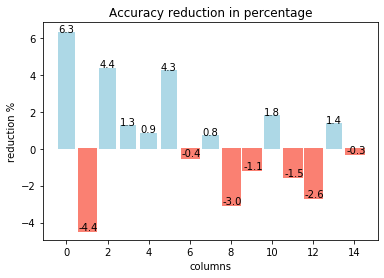

In [22]:
fig, ax = plt.subplots()
ax.set_xlabel('columns')
ax.set_ylabel('reduction %')
ax.set_title('Accuracy reduction in percentage')
label = range(15)

vert_bars = ax.bar(range(15),temp, color='lightblue', align='center')
for bar, height,(x,y) in zip(vert_bars,temp,enumerate(label)):
    plt.text(x - 0.4, height, '%.1f' % height)
    if height < 0:
        bar.set(edgecolor='darkred', color='salmon', linewidth=3)
plt.show()


from the result above we can know that the features/columns `0,2,5`are very imorptant, columns `3,4,7,10,13` are less important, the rest are trivial

## Task 3: Discrete AdaBoost with Decision Stumps
 
*For all students other than B.Sc. Data Science.*  

In this task, you will implement the discrete AdaBoost algorithm using decision stumps as weak learners. Your training will run until either `n_learners` weak learners have been added or a perfect accuracy on the training data set is achieved. Use the function `initialize_decision_stumps` to create decision stumps, which you can train on your weighted data using `fit` and predict using `predict`. The decision stumps are instances of the class [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In addition, you will evaluate your model on the test data (`X_test`, `y_test`) using scikit-learn with the methods shown in the lecture (precision, recall, F1-score, confusion matrices, ...). Feel free to import any functions you need from scikit-learn for this purpose.

In [45]:
def initialize_decision_stump():
    stump = DecisionTreeClassifier(criterion='entropy', max_depth=1)
    return stump


class AdaBoostClassifier(object):
    def __init__(self, n_learners):
        self.n_learners = n_learners
        # Add any initialization you need here.
        self.theta = np.ones(n_learners)
        self.stumps = [initialize_decision_stump() for i in range(n_learners)]
        self.weights = 0

        
    def fit(self, X, y):
        # Implement your solution here.
        weights = np.ones(len(X))/len(X)
        theta = self.theta
        stumps = self.stumps
        for i in range(self.n_learners):
            stumps[i].fit(X, y, weights)
            miss = 0
            counts = np.zeros(X.shape[0])
            for j, weight, predict, y0 in zip(range(len(counts)), weights, stumps[i].predict(X), y):
                if predict != y0 :
                    miss += weight / np.sum(weights)
                    counts[j] = 1
            if miss != 0:
                theta[i] =  np.log((1 - miss) / miss)
            else:
                theta[i] = np.inf
            weights *= np.exp(theta[i]*counts)
            weights /= np.sum(weights) 
        self.theta = theta
    
    def predict(self, X):
        # Implement your solution here.
        result = 0
        theta = self.theta
        stumps = self.stumps
        for j in range(self.n_learners):
            result += theta[j] * stumps[j].predict(X)
        
        y_predict_aver = [1 if i >= 0.5 * np.sum(theta) else 0 for i in result ]

        return y_predict_aver


In [72]:
acf = AdaBoostClassifier(50)
acf.fit(X_train,y_train)
accuracy_score(y_train, acf.predict(X_train))

0.8174157303370787

In [73]:
acf.theta

array([1.32086656, 0.8990164 , 0.12929369, 0.14800527, 0.13579396,
       0.34056594, 0.20789839, 0.10274352, 0.07687658, 0.07402966,
       0.07138615, 0.23492516, 0.18746372, 0.0653209 , 0.06325428,
       0.06131445, 0.25742354, 0.15877347, 0.04886316, 0.04769761,
       0.04658637, 0.04552575, 0.04451235, 0.04354309, 0.04261515,
       0.04172594, 0.043631  , 0.08169705, 0.04014532, 0.03935525,
       0.03859568, 0.03786488, 0.03716124, 0.04253681, 0.07634445,
       0.03590589, 0.03527258, 0.03466122, 0.21852231, 0.18209039,
       0.26416309, 0.04709529, 0.07587195, 0.03547912, 0.03486064,
       0.03426336, 0.0336862 , 0.03312817, 0.17120318, 0.09088205])

With a number of 52 base models we receive an accuracy of  75.97765363128491 %


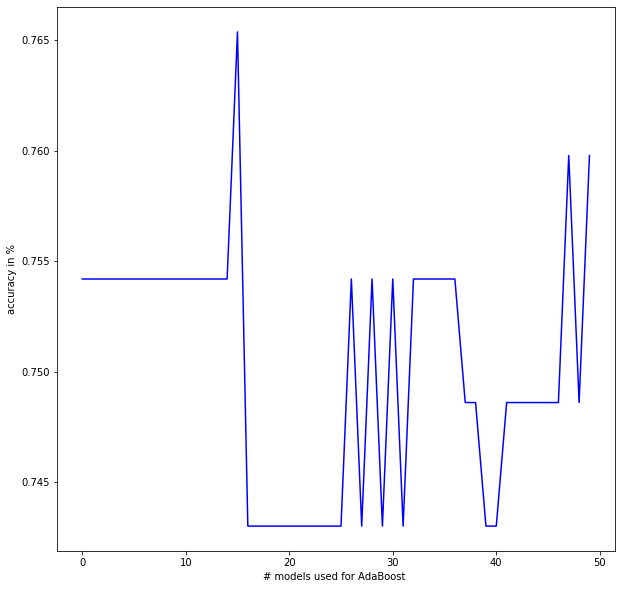

In [59]:
n_learners = 50

fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot()
acc = []
num = 2
for i in range(n_learners):
    acf = AdaBoostClassifier(num)
    acf.fit(X_train,y_train)
    acc.append(accuracy_score(y_test, acf.predict(X_test)))
    num += 1
    
    
ax0.plot(range(len(acc)),acc,'-b')
ax0.set_xlabel('# models used for AdaBoost ')
ax0.set_ylabel('accuracy in %')
print('With a number of',num,'base models we receive an accuracy of ',acc[-1]*100,'%')                    
plt.show()



In [51]:
dcf = DecisionTreeClassifier(criterion='entropy', max_depth= 50)
dcf.fit(X_train, y_train)
dcf.score(X_test, y_test)

0.7318435754189944

In [30]:
# Implement your training and evaluation here. You may reuse the code from Task 1.
from sklearn.metrics import precision_recall_fscore_support
number_of_trees = 8
average = np.zeros(3)
num = 50
for i in range(num):
    rfc = RandomForestClassifier(number_of_trees)
    rfc.fit(X_train, y_train)
    y = rfc.predict(X_test)
    average = np.add(np.array(precision_recall_fscore_support(y_test, y,average = 'binary')[0:3]), average)
print(f'the average precision, recall, fscore is {average/num} ')

the average precision, recall, fscore is [0.74540071 0.62324324 0.67687193] 


In [31]:
# delete
n_learners = 20
stumps = [initialize_decision_stump() for i in range(n_learners)]
weights = np.ones(len(X_train))/len(X_train)
theta = np.ones(n_learners)

for i in range(n_learners):

#     temp = (X_train.T * weights).T
#     print('temp', weights) 
    stumps[i].fit(X_train, y_train, weights)
    
#     errof = np.exp(-y_train * stumps[i].predict(temp))
    
    print('before',stumps[i].score(X_train, y_train, weights))
    
    miss = 0
    counts = np.zeros(X_train.shape[0])
    n = 0
    for j, weight, predict, y in zip(range(len(counts)), weights, stumps[i].predict(X_train), y_train): 
        if predict != y :
            n +=1
            miss += weight/np.sum(weights)
            counts[j] = 1
    if miss != 0:
        print(miss)
        theta[i] =  np.log((1 - miss) / miss)
    else:
        theta[i] = np.inf
   
    weights *= np.exp(theta[i]*counts)
    print(weights.shape, theta[i].shape, counts.shape)
    weights /= np.sum(weights)

    if(stumps[i].score(X_test,y_test) > 0.9):
        break
    print('after',stumps[i].score(X_train,y_train, weights))        
         

def predict(stumps, theta, number_of_learners, X) :
    result = 0
    for j in range(number_of_learners):
        result += theta[j]*stumps[j].predict(X)
        
    y_predict_aver = [1 if i >= 0.5 * np.sum(theta) else 0 for i in result ]

    return y_predict_aver

from sklearn.metrics import precision_recall_fscore_support,accuracy_score
# print(precision_recall_fscore_support(y_train, stumps[1].predict(X_train),average = 'binary'))
# precision_recall_fscore_support(y_train, predict(stumps,theta, 5, X_train),average = 'binary')
print(accuracy_score(y_train, predict(stumps,theta, n_learners, X_train)))
accuracy_score(y_train, predict(stumps,np.ones(n_learners), n_learners, X_train))


before 0.7893258426966293
0.21067415730337122
(712,) () (712,)
after 0.5000000000000008
before 0.7107473309608541
0.28925266903914626
(712,) () (712,)
after 0.5000000000000003
before 0.5322784698775133
0.4677215301224836
(712,) () (712,)
after 0.4999999999999968
before 0.5369339202465968
0.4630660797534046
(712,) () (712,)
after 0.5000000000000012
before 0.5338964186590665
0.4661035813409303
(712,) () (712,)
after 0.4999999999999967
before 0.5843279893936717
0.4156720106063288
(712,) () (712,)
after 0.5000000000000006
before 0.5517882015999447
0.4482117984000532
(712,) () (712,)
after 0.4999999999999978
before 0.5256633088685777
0.47433669113142285
(712,) () (712,)
after 0.5000000000000004
before 0.5192096853134486
0.48079031468655065
(712,) () (712,)
after 0.4999999999999992
before 0.518498966657231
0.48150103334276856
(712,) () (712,)
after 0.49999999999999967
before 0.5178389619332259
0.48216103806677185
(712,) () (712,)
after 0.49999999999999767
before 0.5584626582302464
0.44153734

0.45224719101123595